In [32]:
import math
import torch
from torch import tensor
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
import botorch.acquisition as acqf

import sklearn.datasets as ds
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

gpu = torch.device("cuda:0")
#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("GPU is available: ", torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(gpu)

GPU is available:  True
GeForce GTX 980M
cuda:0


## Optimizing Ridge Regression

In [33]:
# regression design points
delta = 0.1
x_coord = np.arange(-5.0, 5.0, delta)
y_coord = np.arange(-5.0, 5.0, delta)
x_coord, y_coord = np.meshgrid(x_coord, y_coord)

# BO design points
x_ = (torch.arange(0.01, 5.01, 0.01))
y_ = (torch.arange(0.01, 5.01, 0.01))
x_g, y_g = torch.meshgrid(x_, y_)
grid = torch.rot90(torch.stack((x_g, y_g), 2))

X_ = grid.reshape(500*500, 2)

In [34]:
def plot_regression(model, kernel, gamma, llambda, iteration):
    samples = np.ndarray((x_coord.shape[0], x_coord.shape[1]))
    for i in range(x_coord.shape[0]):
        for j in range(x_coord.shape[1]):
            sample = np.asarray([[x_coord[i][j], y_coord[i][j]]])
            samples[i][j] = model.predict(kernel.__call__(sample, Y=X_train))

    p, sub = plt.subplots(1, 1, figsize=(10, 10))
    rr_title = "iteration " + str(iteration) + "\nKRR - gamma=" + str(gamma) + ", lambda=" + str(llambda)
    sub.title.set_text(rr_title)
    con = sub.contour(x_coord, y_coord, samples, colors="k", levels=[0])
    sub.clabel(con, fontsize=9, inline=True)
    sub.imshow(np.flip(samples, axis=0), extent=[-5, 5, -5, 5])
    sub.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color='violet')
    sub.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='darkorange')
    sub.spines['left'].set_position('center')
    sub.spines['bottom'].set_position('zero')
    sub.spines['right'].set_color('none')
    sub.spines['top'].set_color('none')
    sub.xaxis.set_ticks_position('bottom')
    sub.yaxis.set_ticks_position('left')
    plt.plot()

def plot_bo(gp: SingleTaskGP, EI: acqf.ExpectedImprovement):
    fig = plt.figure(figsize=(6, 3))

    sub2 = fig.add_subplot(1, 2, 1)
    sub2.title.set_text('Acquisition Function')
    if len(X_samples) > 1:
        sub2.scatter(X_samples[:, 0][0:-1], X_samples[:, 1][0:-1], color='white')
    sub2.scatter(X_samples[:, 0][-1], X_samples[:, 1][-1], color='red')
    X_ei = X_.unsqueeze(1)
    ei = EI(X_ei).detach().numpy().reshape(500, 500)
    sub2.imshow(ei, extent=[x_[0], x_[-1], y_[0], y_[-1]])
    sub2.spines['left'].set_position('zero')
    sub2.spines['bottom'].set_position('zero')
    sub2.spines['right'].set_color('none')
    sub2.spines['top'].set_color('none')
    sub2.xaxis.set_ticks_position('bottom')
    sub2.yaxis.set_ticks_position('left')
    sub2.set_xlabel('gamma')
    sub2.set_ylabel('lambda')

    sub3 = fig.add_subplot(1, 2, 2)
    sub3.title.set_text('GP posterior')
    posterior_mean = gp.posterior(X_).mean.detach().numpy().reshape(500, 500)
    sub3.imshow(posterior_mean, extent=[x_[0], x_[-1], y_[0], y_[-1]])
    sub3.spines['left'].set_position('zero')
    sub3.spines['bottom'].set_position('zero')
    sub3.spines['right'].set_color('none')
    sub3.spines['top'].set_color('none')
    sub3.xaxis.set_ticks_position('bottom')
    sub3.yaxis.set_ticks_position('left')
    sub3.set_xlabel('gamma')
    sub3.set_ylabel('lambda')

    plt.plot()

In [35]:
# create two moons dataset
#X, y = make_moons(n_samples=1000, noise=0.3, random_state=0)
X, y = ds.make_circles(n_samples = 1000, noise = 0.05, random_state=0)
X = X*1.5

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

def sample_regression(gamma, llambda, iteration, plt = True):
    gamma = float(gamma)
    llambda = float(llambda)

    # train
    kr = KernelRidge(alpha=0.1, gamma=gamma, kernel='precomputed')
    kernel = RBF(length_scale=gamma)
    K = kernel.__call__(X_train)
    kr.fit(K, y_train)

    # test
    #predictions = kr.predict(X_test)
    predictions = kr.predict(kernel.__call__(X_test, Y=X_train))
    score = r2_score(y_test, predictions)
    if plt:
        plot_regression(kr, kernel, gamma, llambda, iteration)
    return tensor(score), K



## Bayesian Optimization

BEST:  tensor([4., 4.]) at iter:  -1


[]

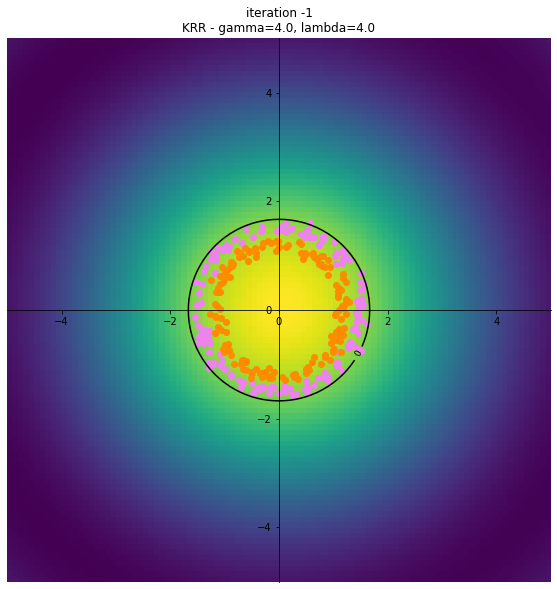

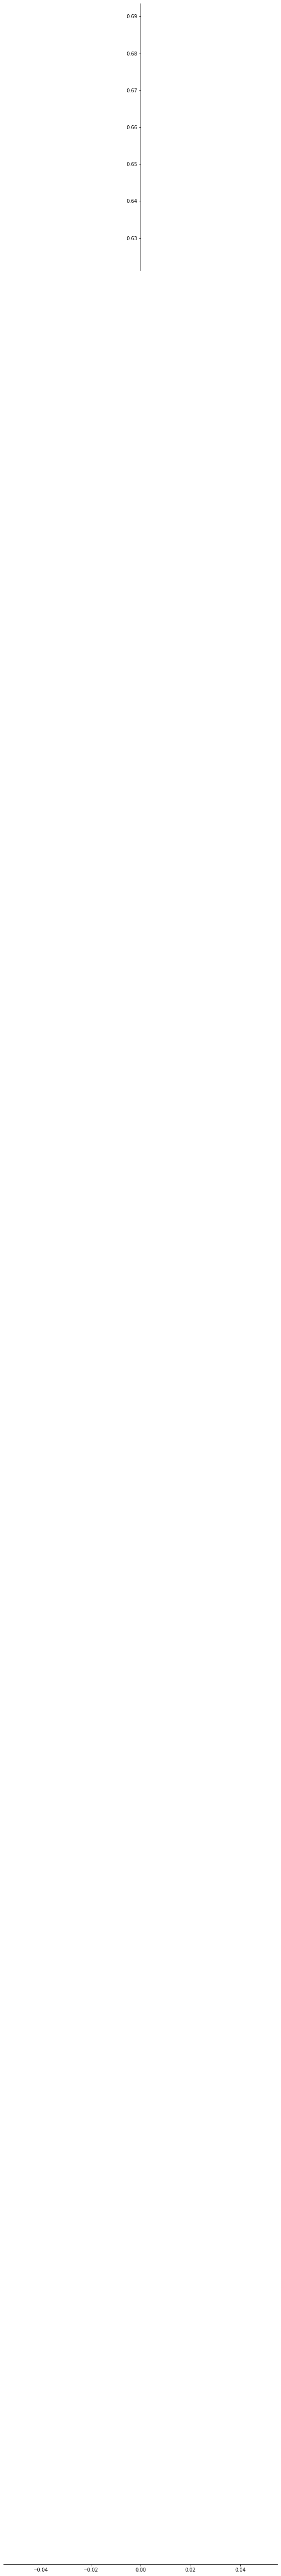

In [36]:
bounds = tensor([[x_[0], y_[0]], [x_[-1], y_[-1]]])
X_samples = tensor([[4., 4.]])
y_samples = sample_regression(X_samples[0][0], X_samples[0][1], -1)[0].reshape(-1, 1)

for i in range(0):
    print("=======================")
    print("iteration:      ", i)

    gp = SingleTaskGP(X_samples, y_samples)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)

    EI = acqf.ExpectedImprovement(
        gp,
        y_samples.max(),
        maximize=True
    )
    candidate, acq_value = optimize_acqf(
        acq_function=EI,
        bounds=bounds,
        q=1,
        num_restarts=1,
        raw_samples=20
    )
    print("current candidate: ", candidate)
    y_new_sample, kernel = sample_regression(candidate[0][0], candidate[0][1], i)
    print("model score for candidate: ", float(y_new_sample))
    X_samples = torch.vstack((X_samples, candidate))
    y_samples = torch.vstack((y_samples, y_new_sample))

    # plot
    plot_bo(gp, EI)

n_iters = len(y_samples)
print("BEST: ", X_samples[torch.argmax(y_samples)], "at iter: ", int(torch.argmax(y_samples))-1)



p, sub = plt.subplots(1, 1, figsize=(10, 10))
sub.plot(np.arange(0, n_iters), y_samples, 'b')
sub.spines['left'].set_position('zero')
sub.spines['bottom'].set_position('zero')
sub.spines['right'].set_color('none')
sub.spines['top'].set_color('none')
sub.xaxis.set_ticks_position('bottom')
sub.yaxis.set_ticks_position('left')
plt.plot()







2.0 %
4.0 %
6.0 %
8.0 %
10.0 %
12.0 %
14.0 %
16.0 %
18.0 %
20.0 %
22.0 %
24.0 %
26.0 %
28.0 %
30.0 %
32.0 %
34.0 %
36.0 %
38.0 %
40.0 %
42.0 %
44.0 %
46.0 %
48.0 %
50.0 %
52.0 %
54.0 %
56.0 %
58.0 %
60.0 %
62.0 %
64.0 %
66.0 %
68.0 %
70.0 %
72.0 %
74.0 %
76.0 %
78.0 %
80.0 %
82.0 %
84.0 %
86.0 %
88.0 %
90.0 %
92.0 %
94.0 %
96.0 %
98.0 %
100.0 %
102.0 %
104.0 %
106.0 %
108.0 %
110.0 %
112.0 %
114.0 %
116.0 %
118.0 %
120.0 %
122.0 %
124.0 %
126.0 %
128.0 %
130.0 %
132.0 %
134.0 %
136.0 %
138.0 %
140.0 %
142.0 %
144.0 %
146.0 %
148.0 %
150.0 %
152.0 %
154.0 %
156.0 %
158.0 %
160.0 %
162.0 %
164.0 %
166.0 %
168.0 %
170.0 %
172.0 %
174.0 %
176.0 %
178.0 %
180.0 %
182.0 %
184.0 %
186.0 %
188.0 %
190.0 %
192.0 %
194.0 %
196.0 %
198.0 %
200.0 %
202.0 %
204.0 %
206.0 %
208.0 %
210.0 %
212.0 %
214.0 %
216.0 %
218.0 %
220.0 %
222.0 %
224.0 %
226.0 %
228.0 %
230.0 %
232.0 %
234.0 %
236.0 %
238.0 %
240.0 %
242.0 %
244.0 %
246.0 %
248.0 %
250.0 %
252.0 %
254.0 %
256.0 %
258.0 %
260.0 %
262.0 %
264.0

[]

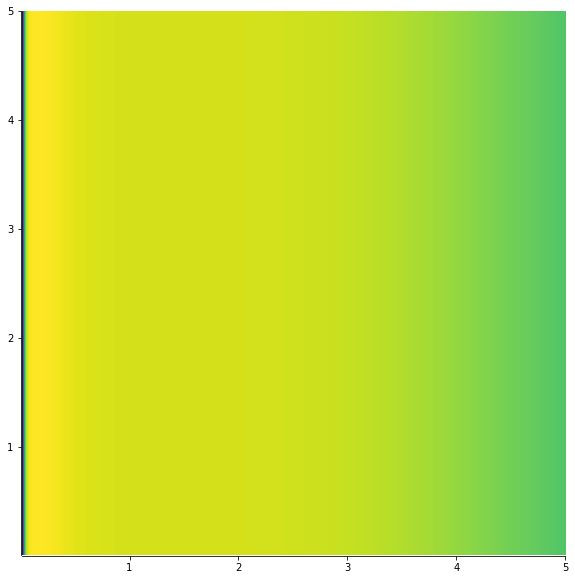

In [38]:
#x_ = (torch.arange(0.01, 5.01, 0.1))
#y_ = (torch.arange(0.01, 5.01, 0.1))
x_g, y_g = torch.meshgrid(x_, y_)
grid = torch.rot90(torch.stack((x_g, y_g), 2))

grid_search = torch.zeros((len(x_), len(y_)))
iter = 0
for i in range(len(x_)):
    #break
    for j in range(len(y_)):
        iter += 1
        if iter%50 == 0:
            print(iter/2500, "%")
        sample_point = grid[i][j]
        score = float(sample_regression(sample_point[0], sample_point[1], iteration=i, plt=False)[0])
        #print(score)
        grid_search[i][j] = score
p, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.imshow(grid_search, extent=[x_[0], x_[-1], y_[0], y_[-1]])

ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.xlim(x_[0], x_[-1])
plt.ylim(y_[0], y_[-1])
plt.plot()